# Model Based Collaborative Filtering Recommender

The goal of the **recommender system** is to predict user preference for a set of items based on the past experience. Two the most popular approaches are Content-Based and Collaborative Filtering.

**Collaborative filtering** is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.

**Model based approach** involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.

The goal of this exercise is to compare SVD and NMF algorithms, try different configurations of parameters and explore obtained results.

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import functions as f
import river

This analysis will focus on book recommendations based on [Book-Crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). To reduce the dimensionality of the dataset and avoid running into memory error it will focus on users with at least 3 ratings and top 10% most frequently rated books. It consists of 176,594 records.

The recommender systems will be built using [surprise package](https://surprise.readthedocs.io/en/stable/getting_started.html) (Matrix Factorization - based models).

In [7]:
df = pd.read_csv('data/ratings_top.csv')

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [8]:
print('Number of ratings: %d\nNumber of books: %d\nNumber of users: %d' % (len(df), len(df['isbn'].unique()), len(df['user_id'].unique())))

Number of ratings: 176594
Number of books: 16766
Number of users: 20155


## Using the River package

In [9]:
from river import datasets, stream
r_df = pd.read_csv('data/ratings_top.csv', header=0, names=['user', 'item', 'rating'])
y = r_df.pop('rating')
X_y = stream.iter_pandas(r_df, y)
cache = stream.Cache()

In [10]:
from river import optim, reco, metrics,preprocessing
def readData():
    r_df = pd.read_csv('data/ratings_top.csv', header=0, names=['user', 'item', 'rating'])
    y = r_df.pop('rating')
    return stream.iter_pandas(r_df, y)
book_titles = pd.read_csv('data/books.csv', usecols=['isbn'])
baseline_params = {
    'optimizer': optim.SGD(0.025),
    'l2': 0.,
    'initializer': optim.initializers.Zeros()
}

model = preprocessing.PredClipper(
    regressor=reco.Baseline(**baseline_params),
    y_min=1,
    y_max=10
)

model = reco.Baseline(optimizer=optim.SGD(0.005))
metric = metrics.MAE() + metrics.RMSE()
X_y = readData()
for x, y in X_y:
    y_pred = model.predict_one(**x)
    
    metric.update(y_pred=y_pred, y_true=y)
    _ = model.learn_one(**x, y=y)
    
print(metric)
print(model.rank(193458, book_titles.isbn.to_list()[:100]))


MAE: 1.352354, RMSE: 1.710199
['0446310786', '0449005615', '0804106304', '0345465083', '0553582747', '0671623249', '0140067477', '1841721522', '8445071777', '0345417623', '0060168013', '1853260053', '0452264464', '8445071769', '0671867156', '0399135782', '0609804618', '0380715899', '1558531025', '0060914068', '042518630X', '0394895894', '0679429220', '0340767936', '0374157065', '8445071408', '0679810307', '0195153448', '0060973129', '0393045218', '0425176428', '0671870432', '0679425608', '074322678X', '0771074670', '080652121X', '0887841740', '1552041778', '1558746218', '1567407781', '1575663937', '1881320189', '1879384493', '0061076031', '0439095026', '0689821166', '0684823802', '0425163091', '3404921038', '3442353866', '3442410665', '3442446937', '038078243X', '055321215X', '067176537X', '0812523873', '0156047624', '0245542957', '0553280333', '0961769947', '0964778319', '0679865691', '2070423204', '0345260317', '0394743741', '1853262404', '0312970242', '1414035004', '0451625889', '15

In [11]:
biased_mf_params = {
    'n_factors': 10,
    'bias_optimizer': optim.SGD(0.025),
    'latent_optimizer': optim.SGD(0.05),
    'weight_initializer': optim.initializers.Zeros(),
    'latent_initializer': optim.initializers.Normal(mu=0., sigma=0.1, seed=73),
    'l2_bias': 0.,
    'l2_latent': 0.
}

model = reco.BiasedMF(**biased_mf_params)

metric = metrics.MAE() + metrics.RMSE()
X_y = readData()
for x, y in X_y:
    y_pred = model.predict_one(user=x['user'], item=x['item'])
    
    metric.update(y_pred=y_pred, y_true=y)
    _ = model.learn_one(**x, x=x, y=y)
    
print(metric)

MAE: 1.277842, RMSE: 1.641593


## SVD and NMF models comparison

Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training / testing time.

In [12]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse    1.605498
test_mae     1.242236
fit_time     1.982254
test_time    0.540564
dtype: float64

In [13]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse    2.625657
test_mae     2.242587
fit_time     4.788131
test_time    0.451066
dtype: float64

## Optimisation of SVD algorithm

Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.

It is used to find the best setting of parameters:
* n_factors - the number of factors
* n_epochs - the number of iteration of the SGD procedure
* lr_all - the learning rate for all parameters
* reg_all - the regularization term for all parameters

As a result, regarding the majority of parameters, the default setting is the most optimal one. The improvement obtained with Grid Search is very small.

In [14]:
param_grid = {'n_factors': [80,100,120],
              'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#1.5981785240945765
#{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}

KeyboardInterrupt: 

## Analysis of Collaborative Filtering model results

In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

In [15]:
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [23]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])

df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,details,impossible,pred_rating_round,abs_err
34513,28820,0671467263,8.0,7.357391,{'was_impossible': False},False,7.0,0.642609
24916,156243,8838910987,8.0,7.792367,{'was_impossible': False},False,8.0,0.207633
13861,159868,0061092568,8.0,8.365186,{'was_impossible': False},False,8.0,0.365186
20095,217121,0552128481,5.0,6.758962,{'was_impossible': False},False,7.0,1.758962
9717,102129,0316785644,6.0,7.988546,{'was_impossible': False},False,8.0,1.988546


### Distribution of actual and predicted ratings in the test set

According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores - between 7 and 10. The mode equals 8 but count of ratings 7, 9, 10 is also noticeable. The distribution of predicted ratings in the test set is visibly different. One more time, 8 is a mode but scores 7, 9 and 10 are clearly less frequent.

It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings.

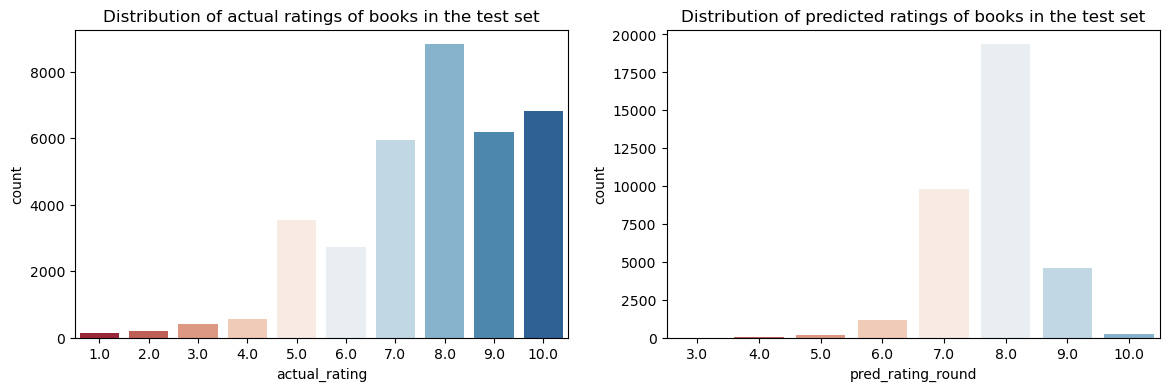

In [17]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

### Absolute error of predicted ratings

The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 10.

How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations.

C:\Users\DELL\AppData\Local\Temp\ipykernel_8616\3785201354.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)


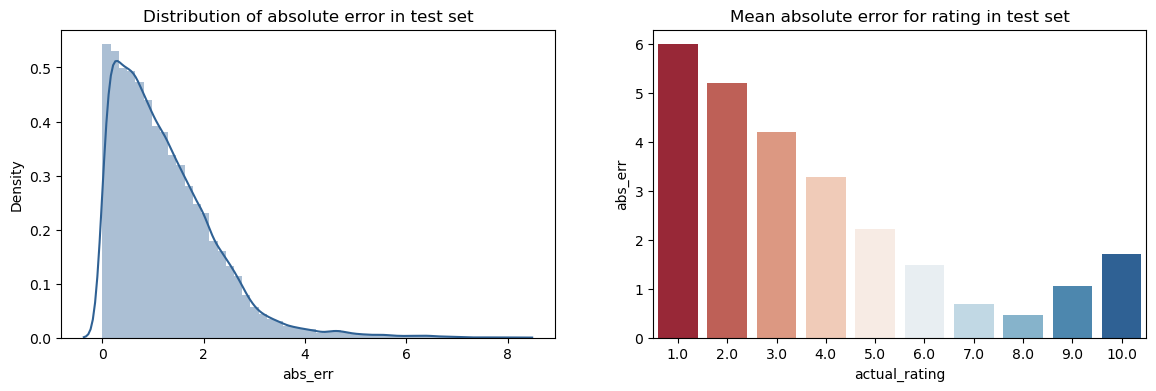

In [18]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

### Analysis of predicted ratings of a particular user

For this part of the analysis, the user with id 193458 was selected. By analyzing book ratings by this user, it can be noted that he/she likes diverse types of readings: English romantic novels (Pride and Prejudice, Sense and Sensibility), fantasy (Narnia) as well as historical novels (Schindler's List). Among the recommended books there are other works from Narnia's series, two historical novels and one romance which correlates with user's previous preferences.

In [19]:
df_books = pd.read_csv('data/books.csv')

df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext['book_title_short'] = df_ext['book_title'].apply(f.short_title)
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

In [20]:
selected_user_id = 193458
df_user = df_ext[df_ext['user_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['book_rating']>=9)].sample(10)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
124951,193458,0679429220,9,Midnight in the Garden of Good and Evil: A Sav...,Midnight in the Garden of Good and Evil:,NaN
124961,193458,1853260002,10,Pride &amp; Prejudice (Wordsworth Classics),Pride &amp; Prejudice (Wordsworth Classics),NaN
124950,193458,0671880314,9,Schindler's List,Schindler's List,NaN
124924,193458,0345342569,9,Shoeless Joe,Shoeless Joe,NaN
124906,193458,0064471055,9,Prince Caspian (rack) : The Return to Narnia (...,Prince Caspian (rack) : The Return to Narnia,NaN
124923,193458,0330352695,9,Four Letters of Love,Four Letters of Love,NaN
124954,193458,0789404257,9,Eyewitness Travel Guide to Italy (revised),Eyewitness Travel Guide to Italy (revised),NaN
124912,193458,014011369X,9,"And the Band Played on: Politics, People, and ...","And the Band Played on: Politics, People,",NaN
124913,193458,0140298479,9,Bridget Jones: The Edge of Reason,Bridget Jones: The Edge of Reason,NaN
124918,193458,0142001740,9,The Secret Life of Bees,The Secret Life of Bees,NaN


### Train set: Top rated books

![](img/train_actual.jpg)

In [21]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
124905,193458,0064471047,9,"The Lion, the Witch, and the Wardrobe (The Chr...","The Lion, the Witch, and the Wardrobe (The",8.484346
124925,193458,0345361792,10,A Prayer for Owen Meany,A Prayer for Owen Meany,8.417446
124911,193458,0064471101,9,The Magician's Nephew (rack) (Narnia),The Magician's Nephew (rack) (Narnia),8.399889
124914,193458,0140620125,9,Wuthering Heights (Penguin Popular Classics),Wuthering Heights (Penguin Popular Classics),8.324708
124942,193458,0451169530,8,The Stand: Complete and Uncut,The Stand: Complete and Uncut,8.248568


### Test set: predicted top rated books

![](img/test_pred.jpg)

In [22]:
df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)

,user_id,isbn,book_rating,book_title,book_title_short,pred_rating
124925,193458,0345361792,10,A Prayer for Owen Meany,A Prayer for Owen Meany,8.417446
124905,193458,0064471047,9,"The Lion, the Witch, and the Wardrobe (The Chr...","The Lion, the Witch, and the Wardrobe (The",8.484346
124907,193458,0064471063,9,The Horse and His Boy,The Horse and His Boy,8.117325
124911,193458,0064471101,9,The Magician's Nephew (rack) (Narnia),The Magician's Nephew (rack) (Narnia),8.399889
124914,193458,0140620125,9,Wuthering Heights (Penguin Popular Classics),Wuthering Heights (Penguin Popular Classics),8.324708


### Test set: actual top rated books

![](img/test_actual.jpg)